In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
from liana.method.sp._Misty import MistyData
from liana.method.sp._misty_constructs import genericMistyData, lrMistyData

In [3]:
from liana.pl._misty_plots import plot_target_metrics, plot_interactions, plot_contributions

In [4]:
import plotnine as p9

In [5]:
adata = sc.read_h5ad('liana/tests/data/synthetic.h5ad')

In [6]:
misty = genericMistyData(intra=adata, bandwidth=10, cutoff=0, set_diag=False, add_juxta=True)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [7]:
misty(seed = 42, verbose = True, n_estimators = 100)

Now learning: prodD: 100%|██████████| 11/11 [00:20<00:00,  1.88s/it]


In [ ]:
misty.uns['target_metrics'].sort_values('gain_R2').head(10)

In [ ]:
plot_target_metrics(misty, stat='intra_R2', return_fig=True)

In [ ]:
plot_target_metrics(misty, stat='multi_R2')

In [ ]:
plot_target_metrics(misty, stat="multi_R2")

In [ ]:
plot_contributions(misty, return_fig=True)

In [ ]:
misty.uns['interactions'].sort_values(by='importances', ascending=False).head(10)

Linear Misty

In [ ]:
misty(seed = 42, verbose = True, model='linear', k_cv=10, bypass_intra=True)

In [ ]:
plot_target_metrics(misty, stat='intra_R2', return_fig=True)

In [ ]:
plot_target_metrics(misty, stat='multi_R2')

In [ ]:
plot_target_metrics(misty, stat="multi_R2")

In [ ]:
plot_contributions(misty, return_fig=True)

In [ ]:
misty.uns['interactions'].sort_values(by='importances', ascending=False).head(10)

LR Misty

In [ ]:
from liana.testing._sample_anndata import generate_toy_spatial

In [ ]:
adata = generate_toy_spatial()
misty = lrMistyData(adata, bandwidth=10, set_diag=True, cutoff=0)

In [ ]:
misty(bypass_intra=True, model='linear')

In [ ]:
plot_interactions(misty, 'extra', return_fig=True)

Test on real data

In [8]:
import decoupler as dc
import liana as li

In [9]:
import squidpy as sq
from scipy.sparse import csr_matrix
from anndata import AnnData

In [10]:
adata = sq.datasets.visium_hne_adata()

In [11]:
## cluster column to binary matrix
X = csr_matrix(pd.get_dummies(adata.obs['cluster']).values)
var = pd.DataFrame(index=pd.get_dummies(adata.obs['cluster']).columns)
obs = adata.obs.copy()

In [12]:
intra = AnnData(X=X, obs=obs, var=var, dtype='int64', obsm=adata.obsm)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [13]:
net = dc.get_dorothea(organism='mouse', levels=['A','B','C'])
net

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


,source,confidence,target,weight
0,Myc,A,Tert,1.000000
1,E2f1,A,Dram1,1.000000
2,E2f1,A,Dnmt1,1.000000
3,E2f1,A,Ctnnbip1,1.000000
4,E2f1,A,Casp7,1.000000
...,...,...,...,...
28414,Gata3,C,Pth2r,0.333333
28415,Gata3,C,Psma6,0.333333
28416,Gata3,C,Prom1,0.333333
28417,Gata3,C,Rab30,0.333333


In [14]:
dc.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

Running mlm on mat with 2688 samples and 18078 targets for 272 sources.


100%|██████████| 1/1 [00:06<00:00,  6.56s/it]


In [15]:
extra = li.fun.obsm_to_adata(adata, 'mlm_estimate')

In [16]:
intra.shape

(2688, 15)

In [17]:
extra.shape

(2688, 272)

In [33]:
misty = genericMistyData(intra=intra, 
                        #  extra=extra,
                         bandwidth=200, 
                         cutoff=0.05, 
                         set_diag=False,
                         add_juxta=True,
                         add_para=False,
                         nz_threshold=0
                         )

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [41]:
# misty(verbose=True, n_estimators=100, bypass_intra=True)
misty(verbose=True, model='rf', bypass_intra=True, n_jobs=-1, predict_self=False)

Now learning: Thalamus_2: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]                   


In [42]:
misty.uns['target_metrics'].sort_values('gain_R2', ascending=False)

,target,intra_R2,multi_R2,gain_R2,juxta
7,Hypothalamus_1,0,0.886130,0.886130,1.0
13,Thalamus_1,0,0.876584,0.876584,1.0
2,Cortex_3,0,0.803682,0.803682,1.0
12,Striatum,0,0.801905,0.801905,1.0
0,Cortex_1,0,0.787790,0.787790,1.0
1,Cortex_2,0,0.777996,0.777996,1.0
14,Thalamus_2,0,0.777805,0.777805,1.0
6,Hippocampus,0,0.720080,0.720080,1.0
11,Pyramidal_layer_dentate_gyrus,0,0.691797,0.691797,1.0
5,Fiber_tract,0,0.643739,0.643739,1.0


In [45]:
misty.uns['interactions'].sort_values('importances', ascending=False).head(20)

,target,predictor,intra_group,extra_group,view,importances
146,Pyramidal_layer,Hippocampus,None,None,juxta,0.357039
59,Cortex_5,Cortex_4,None,None,juxta,0.338904
93,Hippocampus,Pyramidal_layer,None,None,juxta,0.219596
94,Hippocampus,Pyramidal_layer_dentate_gyrus,None,None,juxta,0.192192
45,Cortex_4,Cortex_5,None,None,juxta,0.189962
160,Pyramidal_layer_dentate_gyrus,Hippocampus,None,None,juxta,0.189494
163,Pyramidal_layer_dentate_gyrus,Lateral_ventricle,None,None,juxta,0.186689
204,Thalamus_2,Hypothalamus_2,None,None,juxta,0.183247
149,Pyramidal_layer,Lateral_ventricle,None,None,juxta,0.180865
190,Thalamus_1,Hypothalamus_2,None,None,juxta,0.174609


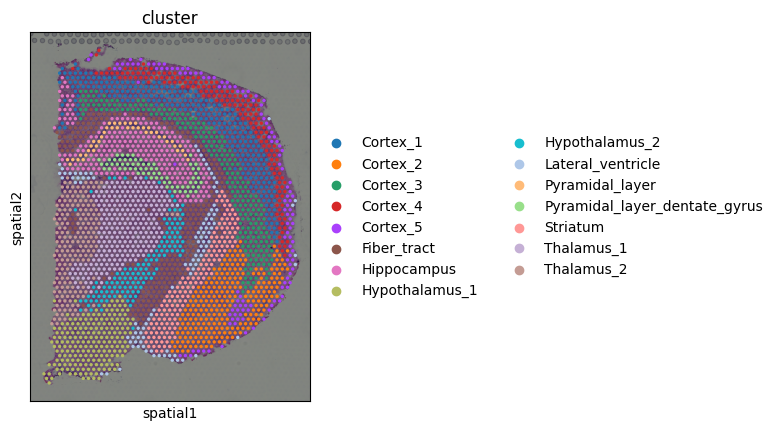

In [44]:
sc.pl.spatial(adata, color='cluster')